In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from dateutil.relativedelta import relativedelta

# Exploratory data analysis

In [2]:
# load data
stocks = pd.read_csv('data/returns/raw/stock_returns.csv', index_col=0)

In [3]:
stocks.index = pd.to_datetime(stocks.index)

In [4]:
stocks.shape

(2644, 16)

In [5]:
stocks.isna().sum()

AMGN      0
GSK       0
NVO       0
REGN      1
VRTX      2
BIIB      0
GILD      0
ALXN      0
BMY       0
JNJ       0
LLY       0
MRK       0
PFE       0
AZN       0
NVS       0
ABBV    883
dtype: int64

<AxesSubplot:ylabel='Count'>

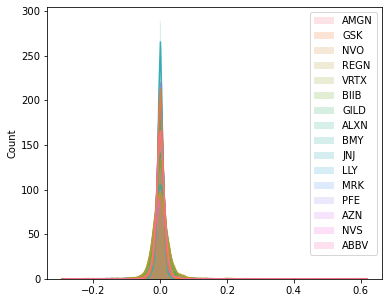

In [6]:
fig, ax = plt.subplots(figsize=(6, 5))
sns.histplot(stocks, ax=ax, fill=True, kde=True, bins=500, element="step", linewidth=0.0, alpha=0.2)

In [7]:
snp500 = pd.read_csv('data/returns/raw/market_returns.csv', index_col=0)

In [8]:
snp500.index = pd.to_datetime(snp500.index)

In [9]:
snp500.isna().sum()

^GSPC    0
dtype: int64

<AxesSubplot:xlabel='date'>

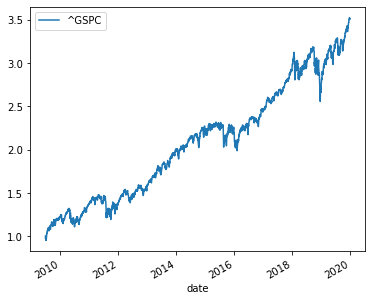

In [10]:
fig, ax = plt.subplots(figsize=(6, 5))
(snp500+1).cumprod().plot(ax=ax)

In [11]:
rf = pd.read_csv('data/returns/raw/rf_returns.csv', index_col=0)

In [12]:
rf.index = pd.to_datetime(rf.index)

In [13]:
rf.isna().sum()

rf    0
dtype: int64

<AxesSubplot:xlabel='date'>

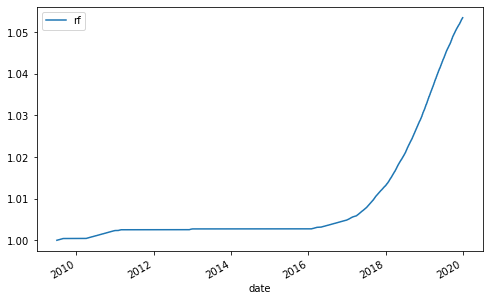

In [14]:
fig, ax = plt.subplots(figsize=(8, 5))
(rf+1).cumprod().plot(ax=ax)

# Data cleaning

In [15]:
stocks[['REGN','VRTX']] = stocks[['REGN','VRTX']].fillna(0)

In [16]:
stocks[['ABBV']].loc['2013-01-03':, :].isna().sum()

ABBV    0
dtype: int64

# Save clean returns

In [17]:
filename = 'data/returns/clean/stock_returns.csv'

if not os.path.exists(filename):
    stocks.to_csv(filename)

In [18]:
filename = 'data/returns/clean/market_returns.csv'

if not os.path.exists(filename):
    snp500.to_csv(filename)

In [19]:
filename = 'data/returns/clean/rf_returns.csv'

if not os.path.exists(filename):
    rf.to_csv(filename)

# Compute adjusted returns

In [20]:
ex_stocks = pd.DataFrame(data=stocks.values - rf.values, columns=stocks.columns,
                         index=stocks.index)

In [21]:
ex_market = pd.DataFrame(data=snp500.values - rf.values, columns=snp500.columns,
                         index=snp500.index)

In [22]:
# compute beta using 6-month historical data
beta = pd.DataFrame(columns=stocks.columns, index=stocks[stocks.index >= '2010-01-01'].index)

In [23]:
for i, b in beta.iterrows():
    ret = stocks[(stocks.index < i) & (stocks.index >= i - relativedelta(months=6))].values
    mkt = snp500[(snp500.index < i) & (snp500.index >= i - relativedelta(months=6))].values
    covariance = np.dot(mkt.T - mkt.mean(), ret - ret.mean(axis=0)) / (mkt.shape[0]-1)
    variance = np.var(mkt)
    beta.at[i, :] = covariance/variance 

In [24]:
adj_returns = pd.DataFrame(data=ex_stocks[ex_stocks.index > '2010-01-01'].values - \
                           beta.values * ex_market[ex_market.index > '2010-01-01'].values,
                           index = beta.index, columns=beta.columns)

In [25]:
filename = 'data/returns/clean/adj_stock_returns.csv'

if not os.path.exists(filename):
    adj_returns.to_csv(filename)

In [26]:
beta.shape

(2516, 16)